The following Code has been compiled with Python 3.12.1 version

Reading CSV Files

In [1]:
import numpy as np
def read_csv ( csv_path ):
  np_path_XYs = np . genfromtxt ( csv_path , delimiter = ',')
  path_XYs = []
  for i in np . unique ( np_path_XYs [: , 0]):
    npXYs = np_path_XYs [ np_path_XYs [: , 0] == i ][: , 1:]
    XYs = []
    for j in np . unique ( npXYs [: , 0]):
      XY = npXYs [ npXYs [: , 0] == j ][: , 1:]
      XYs . append ( XY )
    path_XYs . append ( XYs )

  return path_XYs

Plotting Shapes in CSV file

In [2]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
# plt.switch_backend('agg')
import numpy as np
import matplotlib . pyplot as plt
import os

colours = ['r','b','g','c']


def plot( path_XYs):
  fig , ax = plt . subplots ( tight_layout = True , figsize =(8 , 8))
  for i , XYs in enumerate ( path_XYs ):
    c = colours[ i % len( colours )]
    for XY in XYs :
      ax . plot ( XY [: , 0] , XY [: , 1] , c =c , linewidth =2)
  ax . set_aspect ( 'equal' )
  plt.axis('off')  # Turn off the axis
  # plt.savefig(os.path.join(output_dir, f"{filename}.png"), bbox_inches='tight', pad_inches=0, dpi=28)
  plt . show ()

Resampling Points

In [3]:
import numpy as np
def determine_resample_spacing(points):
    if len(points)<2:
        return 0
    top_left = np.min(points, axis=0)
    bottom_right = np.max(points, axis=0)
    diagonal = np.linalg.norm(bottom_right - top_left)
    S = diagonal / 50.0
    return S
def resample_points(points, S):
    if(S==0):
        return points
    D = 0
    resampled = [points[0]]
    i = 1
    while i < len(points):
        d = np.linalg.norm(points[i] - points[i - 1])
        if D + d >= S:
            q = points[i - 1] + ((S - D) / d) * (points[i] - points[i - 1])
            resampled.append(q)
            points = np.insert(points, i, q, axis=0)
            D = 0
        else:
            D += d
        i += 1
    return np.array(resampled)

In [4]:
import numpy as np
from scipy.spatial import ConvexHull

def extract_features(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    num_vertices = len(hull_points)
    perimeter = np.sum(np.linalg.norm(np.diff(hull_points, axis=0), axis=1))
    area = hull.volume
    compactness = perimeter ** 2 / area
    angles = []
    for i in range(num_vertices):
        a = hull_points[i]
        b = hull_points[(i + 1) % num_vertices]
        c = hull_points[(i + 2) % num_vertices]
        ba = a - b
        bc = c - b
        angle = np.arccos(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)))
        angles.append(angle)
    
    features = {
        'num_vertices': num_vertices,
        'perimeter': perimeter,
        'area': area,
        'compactness': compactness,
        'angles': angles
    }
    
    return features

Regularizing Curves

In [5]:
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import leastsq
from scipy.spatial import ConvexHull

#Line
def regularize_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    return np.column_stack((X, y_pred))


#Circle
def fit_circle(points):
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)

    def f(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = np.mean(points, axis=0)
    center, _ = minimize(f, center_estimate).x, minimize(f, center_estimate).fun
    radius = calc_R(*center).mean()
    return center, radius

def regularize_circle(points):
    center, radius = fit_circle(points)
    theta = np.linspace(0, 2 * np.pi, len(points))
    circle_points = np.column_stack((center[0] + radius * np.cos(theta),
                                     center[1] + radius * np.sin(theta)))
    return circle_points


#Ellipse
def fit_ellipse(points):
    x = points[:, 0]
    y = points[:, 1]

    def ellipse_residuals(params, x, y):
        xc, yc, a, b, theta = params
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        x_rot = cos_theta * (x - xc) + sin_theta * (y - yc)
        y_rot = -sin_theta * (x - xc) + cos_theta * (y - yc)
        return (x_rot / a) ** 2 + (y_rot / b) ** 2 - 1

    center_estimate = np.mean(points, axis=0)
    a_estimate = np.ptp(x) / 2
    b_estimate = np.ptp(y) / 2
    theta_estimate = 0
    params_estimate = (*center_estimate, a_estimate, b_estimate, theta_estimate)
    params, _ = leastsq(ellipse_residuals, params_estimate, args=(x, y))
    return params

def regularize_ellipse(points):
    xc, yc, a, b, theta = fit_ellipse(points)
    theta_grid = np.linspace(0, 2 * np.pi, len(points))
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    x_ellipse = a * np.cos(theta_grid)
    y_ellipse = b * np.sin(theta_grid)
    x_rot = cos_theta * x_ellipse - sin_theta * y_ellipse
    y_rot = sin_theta * x_ellipse + cos_theta * y_ellipse
    ellipse_points = np.column_stack((xc + x_rot, yc + y_rot))
    return ellipse_points


#Rectangle
def regularize_rectangle(points):

    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    if len(hull_points) != 4:
        return points  # Not a rectangle

    # Find the midpoints of the hull sides
    midpoints = [(hull_points[i] + hull_points[(i + 1) % 4]) / 2 for i in range(4)]
    
    # Regularize sides
    horizontal_sides = sorted(midpoints, key=lambda p: p[1])
    vertical_sides = sorted(midpoints, key=lambda p: p[0])

    top_left = np.mean([horizontal_sides[0], vertical_sides[0]], axis=0)
    top_right = np.mean([horizontal_sides[0], vertical_sides[1]], axis=0)
    bottom_left = np.mean([horizontal_sides[1], vertical_sides[0]], axis=0)
    bottom_right = np.mean([horizontal_sides[1], vertical_sides[1]], axis=0)

    return np.array([top_left, top_right, bottom_right, bottom_left, top_left])

In [6]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.spatial import ConvexHull

#Rounded Rectangle
def regularize_rounded_rectangle(points, radius=10):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    if len(hull_points) != 4:
        return points  # Not a rectangle

    # Find the midpoints of the hull sides
    midpoints = [(hull_points[i] + hull_points[(i + 1) % 4]) / 2 for i in range(4)]
    
    # Regularize sides
    horizontal_sides = sorted(midpoints, key=lambda p: p[1])
    vertical_sides = sorted(midpoints, key=lambda p: p[0])

    top_left = np.mean([horizontal_sides[0], vertical_sides[0]], axis=0)
    top_right = np.mean([horizontal_sides[0], vertical_sides[1]], axis=0)
    bottom_left = np.mean([horizontal_sides[1], vertical_sides[0]], axis=0)
    bottom_right = np.mean([horizontal_sides[1], vertical_sides[1]], axis=0)

    corners = [top_left, top_right, bottom_right, bottom_left]
    
    # Fit quarter circles to the corners
    corner_points = []
    for i, corner in enumerate(corners):
        next_corner = corners[(i + 1) % 4]
        vector = next_corner - corner
        perp_vector = np.array([-vector[1], vector[0]])
        circle_center = corner + radius * perp_vector / np.linalg.norm(perp_vector)
        theta = np.linspace(0, np.pi / 2, 25)
        if i % 2 == 0:
            corner_arc = corner + radius * np.column_stack((np.cos(theta), np.sin(theta)))
        else:
            corner_arc = corner + radius * np.column_stack((np.sin(theta), np.cos(theta)))
        corner_points.append(corner_arc)
    
    rounded_rect_points = np.vstack(corner_points)
    return rounded_rect_points

#Polygons with 'num_sides' sides.
def regularize_polygon(points, num_sides):
    
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    if len(hull_points) != num_sides:
        return points  # Not a regular polygon

    center = np.mean(hull_points, axis=0)
    angles = np.arctan2(hull_points[:, 1] - center[1], hull_points[:, 0] - center[0])
    sorted_points = hull_points[np.argsort(angles)]
    
    angle_step = 2 * np.pi / num_sides
    regular_polygon_points = np.array([
        center + np.array([np.cos(i * angle_step), np.sin(i * angle_step)]) * np.mean(np.linalg.norm(sorted_points - center, axis=1))
        for i in range(num_sides)
    ])
    
    return regular_polygon_points

#Star
def regularize_star(points, num_points):
    center = np.mean(points, axis=0)
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    sorted_points = points[np.argsort(angles)]
    
    radial_distances = np.linalg.norm(sorted_points - center, axis=1)
    inner_points = sorted_points[::2]
    outer_points = sorted_points[1::2]
    
    regular_star_points = []
    angle_step = np.pi / num_points
    for i in range(num_points):
        outer_angle = 2 * i * angle_step
        inner_angle = outer_angle + angle_step
        outer_point = center + np.array([np.cos(outer_angle), np.sin(outer_angle)]) * np.mean(radial_distances[1::2])
        inner_point = center + np.array([np.cos(inner_angle), np.sin(inner_angle)]) * np.mean(radial_distances[::2])
        regular_star_points.append(outer_point)
        regular_star_points.append(inner_point)
    
    return np.array(regular_star_points)

Regularizing for Symmetry

In [7]:
def detect_symmetry(points):
    center = np.mean(points, axis=0)
    points_centered = points - center
    
    def symmetry_score(axis):
        mirrored_points = points_centered - 2 * np.outer(np.dot(points_centered, axis), axis)
        return np.mean(np.linalg.norm(mirrored_points - points_centered, axis=1))
    
    angles = np.linspace(0, np.pi, 180)
    axes = np.column_stack((np.cos(angles), np.sin(angles)))
    scores = np.array([symmetry_score(axis) for axis in axes])
    best_axis = axes[np.argmin(scores)]
    
    return center, best_axis

def regularize_for_symmetry(points):
    center, axis = detect_symmetry(points)
    points_centered = points - center
    mirrored_points = points_centered - 2 * np.outer(np.dot(points_centered, axis), axis)
    symmetric_points = (points_centered + mirrored_points) / 2 + center
    return symmetric_points

Douglas Peucker Algorithm

In [8]:
def complete_curve(points):
    from scipy.interpolate import splprep, splev
    
    # Fit a spline to the points
    tck, u = splprep([points[:, 0], points[:, 1]], s=0, per=True)
    u_fine = np.linspace(0, 1, len(points) * 10)
    x_fine, y_fine = splev(u_fine, tck)
    
    completed_curve = np.column_stack((x_fine, y_fine))
    return completed_curve

def perpendicular_distance(point, start, end):
    if np.array_equal(start, end):
        return np.linalg.norm(point - start)
    # Convert 2D vectors to 3D for cross product
    start_3d = np.append(start, 0)
    end_3d = np.append(end, 0)
    point_3d = np.append(point, 0)
    cross_product = np.cross(end_3d - start_3d, start_3d - point_3d)
    return np.linalg.norm(cross_product) / np.linalg.norm(end_3d - start_3d)

def douglas_peucker(points, epsilon):
    if len(points) < 2:
        return points
    max_dist = 0
    index = 0
    start = points[0]
    end = points[-1]
    for i in range(1, len(points) - 1):
        dist = perpendicular_distance(points[i], start, end)
        if dist > max_dist:
            max_dist = dist
            index = i
    if max_dist > epsilon:
        rec_results1 = douglas_peucker(points[:index+1], epsilon)
        rec_results2 = douglas_peucker(points[index:], epsilon)
        result = np.vstack((rec_results1[:-1], rec_results2))
    else:
        result = np.vstack((start, end))
    return result

Identifying Regular Shapes

In [9]:
def identify_shape(approx):
    num_vertices = len(approx)
    if num_vertices == 3:
        return 'triangle'
    elif num_vertices == 4:
        d1 = distance.euclidean(approx[0], approx[1])
        d2 = distance.euclidean(approx[1], approx[2])
        d3 = distance.euclidean(approx[2], approx[3])
        d4 = distance.euclidean(approx[3], approx[0])
        angles = []
        for i in range(num_vertices):
            p1 = approx[i]
            p2 = approx[(i + 1) % num_vertices]
            p3 = approx[(i + 2) % num_vertices]
            angle = np.arccos(np.clip(np.dot(p2 - p1, p3 - p2) / (np.linalg.norm(p2 - p1) * np.linalg.norm(p3 - p2)), -1.0, 1.0))
            angles.append(angle)
        if np.isclose(d1, d3) and np.isclose(d2, d4) and np.allclose(angles, [np.pi/2] * 4):
            if np.isclose(d1, d2):
                return 'square'
            else:
                return 'rectangle'
    elif num_vertices == 5:
        d1 = distance.euclidean(approx[0], approx[2])
        d2 = distance.euclidean(approx[1], approx[3])
        d3 = distance.euclidean(approx[2], approx[4])
        if np.isclose(d1, d2) and np.isclose(d2, d3):
            return 'star'
    elif num_vertices > 5:
        perimeter = np.sum([distance.euclidean(approx[i], approx[(i+1) % len(approx)]) for i in range(len(approx))])
        area = 0.5 * np.abs(np.dot(approx[:,0], np.roll(approx[:,1], 1)) - np.dot(approx[:,1], np.roll(approx[:,0], 1)))
        circularity = 4 * np.pi * (area / (perimeter ** 2))
        aspect_ratio = (np.max(approx[:, 0]) - np.min(approx[:, 0])) / (np.max(approx[:, 1]) - np.min(approx[:, 1]))
        
        if 0.7 < circularity < 1.2:
            return 'circle'
        elif 0.5 < aspect_ratio < 2.0:
            return 'ellipse'
        else:
            return 'polygon', num_vertices
    return 'irregular shape'

Regularizing Identified Shape

In [10]:
def regularize_shape(points, shape_type):
    if shape_type == 'triangle':
        return points
    elif shape_type == 'square':
        top_left = np.min(points, axis=0)
        bottom_right = np.max(points, axis=0)
        side_length = np.max(bottom_right - top_left)
        return np.array([top_left,
                         [top_left[0] + side_length, top_left[1]],
                         [top_left[0] + side_length, top_left[1] + side_length],
                         [top_left[0], top_left[1] + side_length],
                         top_left])
    elif shape_type == 'rectangle':
        # top_left = np.min(points, axis=0)
        # bottom_right = np.max(points, axis=0)
        # return np.array([top_left,
        #                  [bottom_right[0], top_left[1]],
        #                  bottom_right,
        #                  [top_left[0], bottom_right[1]],
        #                  top_left])
        regularize_rectangle(points)
    elif shape_type == 'circle':
        center = np.mean(points, axis=0)
        radius = np.mean(np.linalg.norm(points - center, axis=1))
        return np.array([center + radius * np.array([np.cos(theta), np.sin(theta)]) for theta in np.linspace(0, 2 * np.pi, 100)])
        # p = regularize_circle(points)
        # return p
    elif shape_type == 'ellipse':
        regularize_ellipse(points)
    elif shape_type == 'star':
        regularize_star(points, 5)
        # center = np.mean(points, axis=0)
        # num_points = 5
        # outer_radius = np.max(np.linalg.norm(points - center, axis=1))
        # inner_radius = outer_radius / 2
        # angles = np.linspace(0, 2 * np.pi, num_points * 2 + 1)
        # star_points = []
        # for i in range(num_points * 2):
        #     radius = outer_radius if i % 2 == 0 else inner_radius
        #     star_points.append(center + radius * np.array([np.cos(angles[i]), np.sin(angles[i])]))
        # return np.array(star_points)
    # elif shape_type=='polygon'
    return points

Main Driving Code- Provide Input CSV File Here

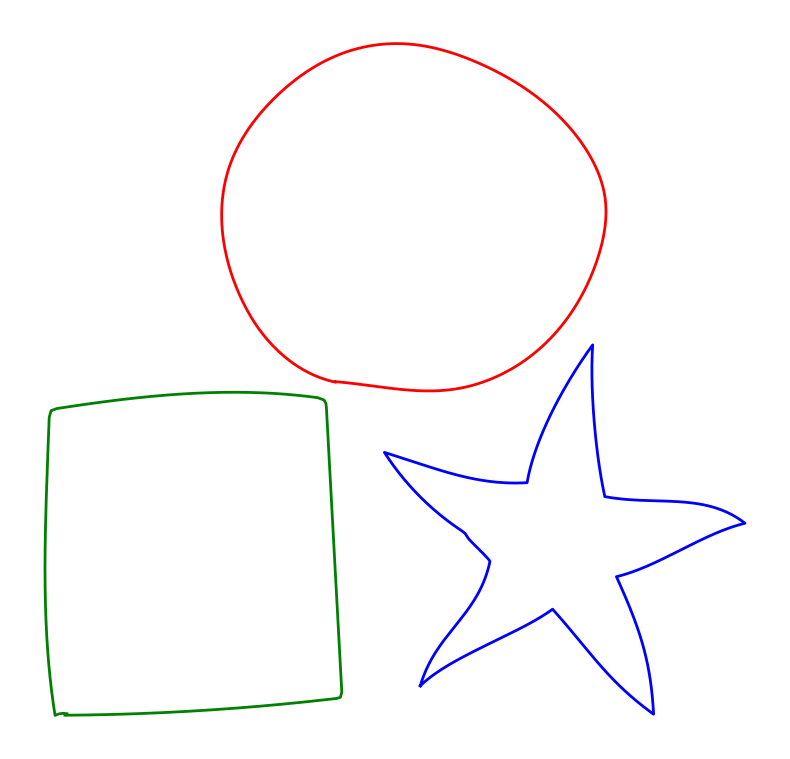

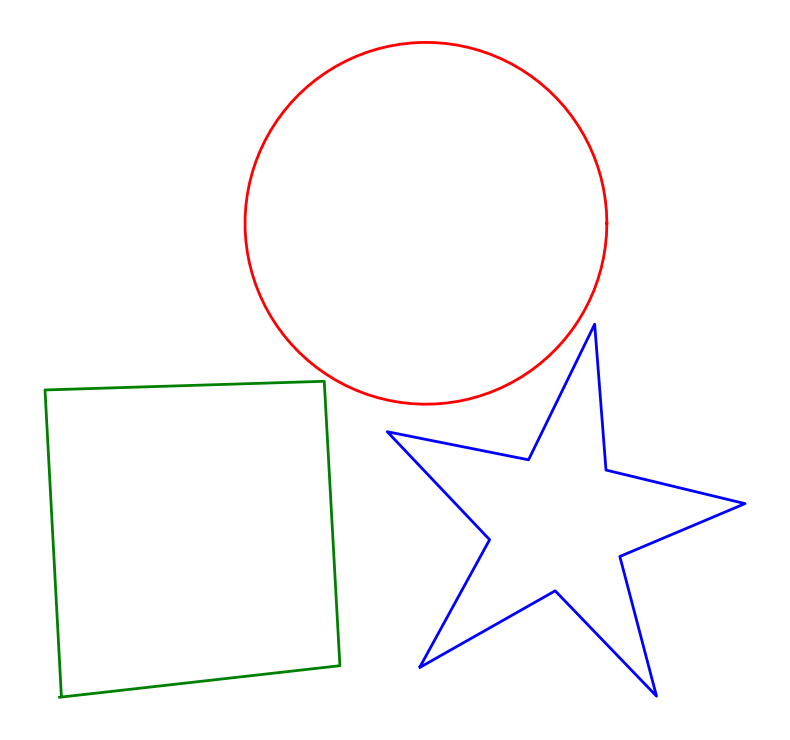

In [11]:
#Give input CSV file here
A = read_csv(r'problems\isolated.csv')
plot(A)
epsilon = 20
B=A.copy()
for i in range(len(A)):
    points = A[i][0]
    S = determine_resample_spacing(points)
    # Resample points
    resampled_points = resample_points(points, S)
    # print(resampled_points)
    corners = douglas_peucker(resampled_points, epsilon)
    approx_points = douglas_peucker(resampled_points, epsilon)
    shape_type = identify_shape(approx_points)
    regularized_points = regularize_shape(approx_points, shape_type)
    rs = regularize_for_symmetry(regularized_points)
    B[i][0]= regularized_points
    

plot(B)

Uploading Regularized Sequential Points in isolated_regularized_sol.csv file

In [12]:
import numpy as np

def write_csv(path_XYs, output_csv_path):
    csv_data = []
    polyline_id = 0
    
    for XYs in path_XYs:
        fragment_id = 0
        
        for XY in XYs:
            for point in XY:
                csv_data.append([polyline_id, fragment_id, point[0], point[1]])
            fragment_id += 1
        polyline_id += 1
    
    
    csv_data = np.array(csv_data)
    np.savetxt(output_csv_path, csv_data, delimiter=',', fmt='%d,%d,%f,%f')
path_XYs = B


#Output csv file is stored in output_csv_files folder. 
output_csv_path = r'output_csv_files\isolated_regularized_sol.csv'
write_csv(path_XYs, output_csv_path)